# Convolutional Neural Network and Adversarial Attacks

En el siguiente código se crea una red neuronal convolucional que identifica dígitos escritos a mano para posteriormente engañarla usando un white box adversarial attack conocido como FGSM

# Importaciones

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Dataset

A continuación descargamos el dataset

In [2]:
#  Cargamos el dataset y lo dividimos en entrenamiento y entreno
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Importante: normalizar los píxeles entre 0 y 1. También se puede usar el método normalize
train_images, test_images = train_images / 255.0, test_images / 255.0

## Comprobamos el formato

Elegimos una imagen y la mostramos junto con su etiqueta

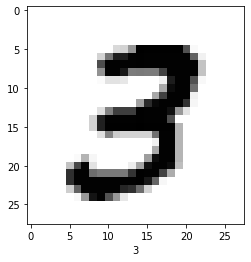

In [3]:
num_imagen = 7  

plt.imshow(train_images[num_imagen] ,cmap=plt.cm.binary)
plt.xlabel(train_labels[num_imagen])
plt.show()

## Reshape
La red espera una entrada de 4 dimensiones: (número imágenes, ancho, alto, canales) de forma que nuestra entrada debe ser (60000, 28, 28, 1). Las imágenes tienen la forma (60000, 28, 28) de forma que el reshape es para especificar el canal.

In [4]:
train_images = train_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

# Definición de la red

In [5]:
# Creamos un modelo secuencial, es decir, la información fluirá de izquierda a derecha
model = models.Sequential()

# Añadimos las capas convolucionaes
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Y posteriormente, las pasamos a capas lineales
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) # Que escojamos 64 neuronas no tiene nada que ver con lo anterior
model.add(layers.Dense(10, activation='softmax'))

# Echemos un vistazo a cómo nos queda la red
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Creación de la red

In [6]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Entrenamiento de la red

In [7]:
entrenamiento = model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1442 - accuracy: 0.9559 - val_loss: 0.0512 - val_accuracy: 0.9853
Epoch 2/3
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0446 - accuracy: 0.9864 - val_loss: 0.0382 - val_accuracy: 0.9879
Epoch 3/3
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0333 - accuracy: 0.9892 - val_loss: 0.0271 - val_accuracy: 0.9911


## Análisis de resultados

Comprobamos ahora en función de los datos de pérdida y precisión si sería beneficial aumentar las épocas o no

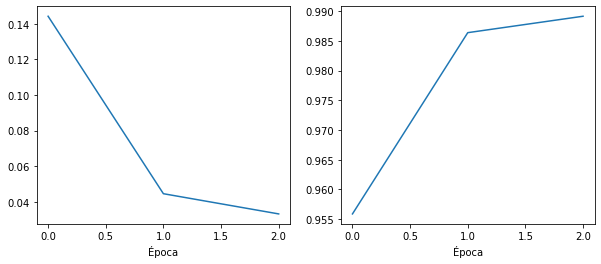

In [8]:
# Mostramos la pérdida y la precisión
plt.figure(figsize=(10,4))
plt.title("Pérdida y precisión")

plt.subplot(121)
plt.xlabel("Época")
plt.plot(entrenamiento.history['loss'], label= "Loss")

plt.subplot(122)
plt.xlabel("Época")
plt.plot(entrenamiento.history['accuracy'], label= "Precisión")

En base a la gráfica se observa que el valor ideal de épocas es 3 (empezamos en 0), pero que con 1 es más que suficiente

# Testeo de la red

En este caso, el modelo comprueba en cada época la precisión con los datos de test, de forma que aumenta de forma más rápida la precisión. Es decir, la siguiente parte daría el mismo resultado que la última época de entrenamiento. Esto sólo tendría sentido si metiéramos un adversarial dataset

In [9]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

10000/10000 [==============================] - 0s 44us/sample - loss: 0.0271 - accuracy: 0.9911


# Predicción de resultados

Comprobamos que las imágenes introducidas corresponden con los valores predichos


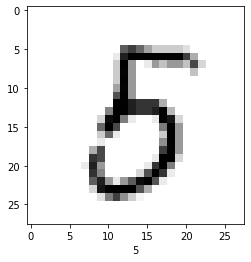

La clase predicha es: 5 con una confianza del 99.99 %


In [10]:
num_imagen = 45

plt.imshow(test_images[num_imagen], cmap=plt.cm.binary)
plt.xlabel(test_labels[num_imagen])
plt.show()

# Para hacer la predicción es siempre mejor realizarla sobre el dataset entero y posteriormente realizar una
print("La clase predicha es:", np.argmax(model.predict([test_images])[num_imagen]), "con una confianza del", 
      round(np.max(model.predict([test_images])[num_imagen])*100, 2), "%")

# Crear adversarial images

## Preparar imagen
Recordemos que la red espera 4 dimensiones y, además, el gradiente trabaja con tensores

In [11]:
# Expandimos la dimensión
imagen = test_images[num_imagen]
imagen = np.expand_dims(imagen, axis = 0)
label = test_labels[num_imagen]

# Convertimos a tensor
imagen = tf.convert_to_tensor(imagen, dtype = tf.float32)

## Creación de la perturbación
Calculamos el gradiente con la predicción y la imagen para obtener su signo

In [12]:
# Definimos la función de pérdida que hemos usado en el modelo
funcion_loss = tf.keras.losses.SparseCategoricalCrossentropy()

# Creamos la función para la definición de la perturbación usando FGSM. El gradiente es la derivada de la pérdida con respecto 
# a la imagen. Para poder llegar a eso necesitamos el entorno GradientTape. En él básicamente le decimos que la imagen es la x 
# y le definimos qué es la y. Con los dos parámetros definidos, podemos calcular el gradiente después y con él, el signo
def crear_patron_adversario(imagen, label):
    with tf.GradientTape() as gt:                
        gt.watch(imagen)                        
        prediccion = model(imagen)
        loss = funcion_loss(label, prediccion)
        
    gradiente = gt.gradient(loss, imagen)
    signo_grad = tf.sign(gradiente)
    return signo_grad

# Llamamos a la función
perturbacion = crear_patron_adversario(imagen, label)

## Visualización de la perturbación

(1, 28, 28, 1)


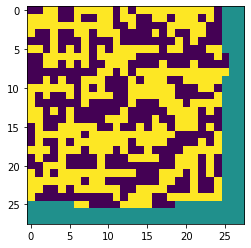

In [13]:
print(perturbacion.shape)

plt.imshow(perturbacion[0]*0.5+0.5) # Los 0.5 hacen que la imagen pase de [-1, 1] a [0, 1]
plt.show()

## Creación de la imagen adversarial
Una vez tenemos la perturbación creada, podemos crear la imagen adversarial a partir de ésta y la imagen original

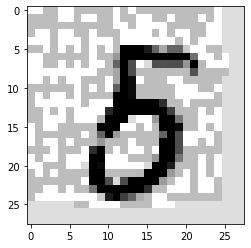

In [14]:
# Creamos la imagen
epsilon = 0.15
imagen_adversarial = test_images[num_imagen] + epsilon*perturbacion[0]*0.5+0.5
imagen_adversarial = tf.clip_by_value(imagen_adversarial, -1, 1)

# Mostramos la imgen
plt.imshow(imagen_adversarial, cmap=plt.cm.binary)
plt.show()

# Predicción con la imagen adversarial

In [15]:
# Primero expandimos una dimensión. Recordemos la forma que espera la red
imagen_adversarial = np.expand_dims(imagen_adversarial, axis = 0)

In [16]:
# Y realizamos la predicción
print("La predicción es:", np.argmax(model.predict(imagen_adversarial)), "con una confianza del", 
      round(np.max(model.predict(imagen_adversarial)),2)*100, "%")

La predicción es: 8 con una confianza del 80.0000011920929 %
